In [40]:
data_dir = 'best-artworks-of-all-time/resized/'

In [41]:
import os
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import random
import glob
import numpy as np
from PIL import Image
import torchvision.transforms.functional as F
import pickle
%matplotlib inline

In [42]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(8, 8))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [43]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

preprocess = tt.Compose([
    tt.ToTensor(),
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.Normalize(*stats)])

In [44]:
years = os.listdir('vincent-van-gogh')
years.remove('unknown-year')

painting_dictionary = dict()

for year in years:
    
    painting_dictionary[year] = dict()

    paintings = glob.glob('vincent-van-gogh/' + year + '/*.jpg')
    
    for painting_index in range(len(paintings)):
        
        painting = paintings[painting_index]

        image = Image.open(painting).convert("RGB")
        
        preprocessed_image = preprocess(image)
        
        painting_dictionary[year][painting_index] = preprocessed_image


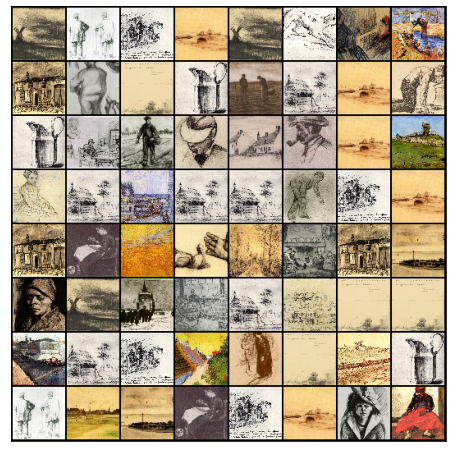

In [45]:
show_paintings = []
from matplotlib.pyplot import figure

for n in range(64):

    year_options = painting_dictionary.keys()
    
    random_year = random.choice(list(year_options))
    
    painting_options = painting_dictionary[random_year].keys()
    
    random_painting =  random.choice(list(painting_options))

    get_painting = painting_dictionary[random_year][random_painting]
    
    show_paintings.append(denorm(get_painting))
    
grid = make_grid(show_paintings)

show(grid)

In [46]:
sample_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(sample_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

device = get_default_device()
generator = to_device(generator, device)

In [47]:
generator.load_state_dict(torch.load('trained_generator.pth'))

<All keys matched successfully>

In [48]:
painting_code_dictionary = dict()

device = get_default_device()
device

years = os.listdir('vincent-van-gogh')
years.remove('unknown-year')

for year in years:
    
    painting_code_dictionary[year] = dict()
    
    painting_options = painting_dictionary[year].keys()
    
    for painting in painting_options:

        target_image = painting_dictionary[year][painting]
        
        target_image = target_image[None, :, :, :]
        
        image_code = torch.randn(1, 128, 1, 1, requires_grad = True)

        generator = to_device(generator, device)

        lr = 1

        torch.cuda.empty_cache()

        opt_i = torch.optim.Adam([image_code], lr=lr, betas=(0.5, 0.999))

        for epoch in range(1, 300):

            opt_i.zero_grad()

            generated_image = generator(image_code)

            loss_function = nn.MSELoss()
            loss = loss_function(target_image, generated_image)

            loss.sum().backward(retain_graph = True)
            opt_i.step()
            
            #if epoch % 10 == 1:

                #show(denorm(np.squeeze(generated_image)))
                #plt.show()

                #print(epoch)

        print(year, painting, loss)
            
        painting_code_dictionary[year][painting] = image_code
        

1890 0 tensor(0.1857, grad_fn=<MseLossBackward>)
1890 1 tensor(0.1036, grad_fn=<MseLossBackward>)
1890 2 tensor(0.1900, grad_fn=<MseLossBackward>)
1890 3 tensor(0.1628, grad_fn=<MseLossBackward>)
1890 4 tensor(0.1704, grad_fn=<MseLossBackward>)
1890 5 tensor(0.1441, grad_fn=<MseLossBackward>)
1890 6 tensor(0.2077, grad_fn=<MseLossBackward>)
1890 7 tensor(0.2069, grad_fn=<MseLossBackward>)
1890 8 tensor(0.2586, grad_fn=<MseLossBackward>)
1890 9 tensor(0.2318, grad_fn=<MseLossBackward>)
1890 10 tensor(0.2664, grad_fn=<MseLossBackward>)
1890 11 tensor(0.3502, grad_fn=<MseLossBackward>)
1890 12 tensor(0.1435, grad_fn=<MseLossBackward>)
1890 13 tensor(0.1529, grad_fn=<MseLossBackward>)
1890 14 tensor(0.1948, grad_fn=<MseLossBackward>)
1890 15 tensor(0.0870, grad_fn=<MseLossBackward>)
1890 16 tensor(0.1589, grad_fn=<MseLossBackward>)
1890 17 tensor(0.1649, grad_fn=<MseLossBackward>)
1890 18 tensor(0.1636, grad_fn=<MseLossBackward>)
1890 19 tensor(0.1853, grad_fn=<MseLossBackward>)
1890 20 te

In [49]:
with open('painting_code_dictionary.pkl', 'wb') as f:
    pickle.dump(painting_code_dictionary, f)